In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.modeling.loggers import Logger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
from flowprintOptimal.sekigo.ood.datasets import SineWaveDataset,FreqWaveDataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import TransformerGenerator,CNNNetwork,Predictor,CNNNetwork1D
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork
from flowprintOptimal.sekigo.ood.GAN.utils import BatchReplacer
from flowprintOptimal.sekigo.ood.GAN.trainers import OODTrainer
from flowprintOptimal.sekigo.flowUtils.flowDatasets import DDQNActivityDataset,MaxNormalizedDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler
import pandas as pd
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.utils.evaluations import evaluateModelOnDataSet
from flowprintOptimal.sekigo.utils.commons import augmentData
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
np.set_printoptions(precision=2)
torch.set_float32_matmul_precision('high')
from copy import deepcopy
from sbo import soft_brownian_offset
from sklearn.metrics import pairwise_distances
from sklearn.metrics import precision_recall_fscore_support

In [2]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Download",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Download",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


True

In [12]:
flows = loadFlows(path= "data/VNAT/flowStore/vnatflows1second.json")
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)
FT_filtered_flows = list(filter(lambda x : x.class_type != "FT",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "FT",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

True

In [3]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .01,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .01,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,all_flows["train_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,all_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["test_flows"])).value_counts())

all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)

ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)

label = len(train_dataset.label_to_index)
for key in ood_dataset.label_to_index:
    ood_dataset.label_to_index[key] = label
    label += 1
ood_support_dataset = DDQNActivityDataset(flows= FT_split_flows["test_flows"],label_to_index= ood_dataset.label_to_index)

{'Video': 0.008195859497708501, 'Conferencing': 0.022477594936261, 'Upload': 0.009999818986434214}
overlapping points = 0
{'Download': 0.04999988167948866}
overlapping points = 0
{'Video': 0.009097623355554911, 'Conferencing': 0.02495073185747089, 'Download': 0.011125283279024218, 'Upload': 0.01110006666021314}
overlapping points = 0
Video           29390
Upload          28251
Conferencing    18371
Name: count, dtype: int64
Video           7320
Upload          7112
Conferencing    4643
Name: count, dtype: int64
Download    65429
Name: count, dtype: int64
Download    16762
Name: count, dtype: int64


In [2]:

id_freq_ranges = [[.1,.4],[1,1.5]]
ood_feeq_ranges = [[2,2.5]]
train_dataset = FreqWaveDataset(num_timesteps= 30,dataset_length= 10000,ts_dim= 1,freq_ranges= id_freq_ranges)
test_dataset = FreqWaveDataset(num_timesteps= 30,dataset_length= 100,ts_dim= 1,freq_ranges= id_freq_ranges)
ood_dataset = FreqWaveDataset(num_timesteps= 30,dataset_length= 5000,ts_dim= 1,freq_ranges= ood_feeq_ranges)


In [4]:
class VAETrainer:
    def __init__(self,encoder : nn.Module,decoder : nn.Module,classifier : nn.Module,compile : bool,logger : Logger,grad_clip: int,ortho_vectors,device):
        self.device = device
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.classifier = classifier.to(device)
        self.logger = logger
        self.ortho_vectors = ortho_vectors.to(device)

        self.grad_clip = grad_clip
        if compile:
            self.encoder = torch.compile(self.encoder)
            self.decoder = torch.compile(self.decoder)
            self.classifier = torch.compile(self.classifier)


        # losses
        self.bce_loss = nn.BCELoss(reduction= 'none')
        self.mse_loss = nn.MSELoss(reduction= "sum")
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction= "sum")
    


    def getClassifierOut(self,dataset):
        loader = DataLoader(dataset= dataset,batch_size= 32)
        self.classifier.eval()
        predictions,ood_scores,labels = [],[],[]
        with torch.no_grad():
            for batch in loader:
                model_out = self.classifier(batch["data"].float().to(self.device))[0]
                batch_labels = batch["label"].cpu().numpy().tolist()
                batch_predictions = torch.argmax(model_out,dim= -1).cpu().numpy().tolist()
                batch_ood_scores = F.softmax(model_out,dim= -1)[:,-1].cpu().numpy().tolist()

                predictions.extend(batch_predictions)
                labels.extend(batch_labels)
                ood_scores.extend(batch_ood_scores)
        
        self.classifier.train()
        return np.array(predictions),np.array(labels),np.array(ood_scores)

    def _getEncoderOut(self,X,cond):
        """
        X is (batch_size,seq_len,data_dim)
        """
        mu,log_var = self.encoder(X,cond)
        return mu,log_var

    def _sampleZ(self,mu,log_var):
        sigma = torch.exp(log_var/2)
        epsilon = torch.randn_like(sigma)
      
        z = mu + sigma*epsilon
        return z


    def _getDecoderOut(self,z,cond):
        """
        mu and sigma are (BS,random_dim)
        """
        decoder_out = self.decoder(z,cond)
        return decoder_out


    def _getKLLoss(self,mu,log_var):
        kl_div = (1 - torch.exp(log_var) - torch.pow(mu,2) + log_var)
        kl_div = kl_div.view(kl_div.size(0),-1).mean(dim = -1).sum()
        return -kl_div
    


    def computeKernel(self,x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)

    def computeMmd(self,x, y):
        x_kernel = self.computeKernel(x, x)
        y_kernel = self.computeKernel(y, y)
        xy_kernel = self.computeKernel(x, y)
        mmd = x_kernel.sum() + y_kernel.sum() - 2*xy_kernel.sum()
        return mmd


    def calcF1(self,predictions,labels):
        _,_,f1,_ = precision_recall_fscore_support(labels, predictions, average= "weighted",zero_division=0) 
        return f1


    @staticmethod
    def klScheduler(step,R= 1,max_steps= 1000000,num_cycles= 1):
        if step >= max_steps:
            return 1
        tau = (step%(max_steps//num_cycles))/(max_steps//num_cycles)
        
        if tau <= R:
            return tau
        else:
            return 1
        
    
    def _generateOOD(self,X,labels):
        """
        X and labels are tensors
        """
        ood_in_cond = self.ortho_vectors[labels]
        ood_out_indices = list(map(lambda x : VAETrainer.sampleIndex(curr_index= x,max_index= self.ortho_vectors.size(0)- 1),labels.cpu().numpy().tolist()))
        ood_out_cond = self.ortho_vectors[torch.tensor(ood_out_indices).to(self.device)]

        
        mu,log_var = self._getEncoderOut(X,cond=ood_in_cond)
        z = self._sampleZ(mu= mu,log_var= log_var)
        decoder_out,_ = self._getDecoderOut(z,cond= ood_out_cond)


        re_mu,re_log_var = self._getEncoderOut(decoder_out.detach(),cond= ood_out_cond)
        re_z = self._sampleZ(mu= re_mu,log_var= re_log_var)
        reconstructed, _ = self._getDecoderOut(z= re_z,cond= ood_in_cond)
        return decoder_out,reconstructed
    

    def getOODLoss(self,batch):
        X = batch["data"].float().to(self.device)
        labels = batch["label"].to(device)
        ood_decoder_out,reconstructed = self._generateOOD(X,labels= labels)
        ood_classification_out = self.classifier(ood_decoder_out)[0]
        ood_classification_out_targets = torch.ones_like(labels)*(ood_classification_out.size(-1) - 1)
        ood_classification_loss = self.cross_entropy_loss(ood_classification_out,ood_classification_out_targets)

        re_bce_loss = self.bce_loss(reconstructed,X)
        re_bce_loss = re_bce_loss.view(re_bce_loss.size(0),-1).mean(dim = -1).sum()
        

        return ood_classification_loss,re_bce_loss


    def trainStep(self,step,batch,encoder_optimizer,decoder_optimizer,classifier_optimizer):
        X = batch["data"].float().to(self.device)
        labels = batch["label"].to(device)

        cond = self.ortho_vectors[labels]
        mu,log_var = self._getEncoderOut(X,cond= cond)
        z = self._sampleZ(mu= mu, log_var= log_var)
        decoder_out,decoder_first_layer_out = self._getDecoderOut(z,cond = cond)
        assert decoder_out.shape == X.shape
        assert z.shape == decoder_first_layer_out.shape
        id_classification_loss = self.cross_entropy_loss(self.classifier(decoder_out)[0],labels)
        ood_classification_loss, re_bce_loss = self.getOODLoss(batch= batch)


        classifier_loss = self.cross_entropy_loss(self.classifier(X)[0],labels)
        mmd_loss = self.computeMmd(x= z,y= decoder_first_layer_out)
        bce_loss = self.bce_loss(decoder_out,X)
        bce_loss = bce_loss.view(bce_loss.size(0),-1).mean(dim = -1).sum()
        #bce_loss = bce_loss.view(bce_loss.size(0),-1).mean()
        kl_loss = self._getKLLoss(mu= mu, log_var= log_var)
        beta = VAETrainer.klScheduler(step= step)
        loss = bce_loss + (kl_loss + mmd_loss + id_classification_loss + ood_classification_loss + re_bce_loss)*beta + classifier_loss

        self.encoder.zero_grad(set_to_none= True)
        self.decoder.zero_grad(set_to_none= True)
        self.classifier.zero_grad(set_to_none= True)
       
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        classifier_optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.encoder.parameters(),self.grad_clip)
        torch.nn.utils.clip_grad_norm_(self.decoder.parameters(),self.grad_clip)
        torch.nn.utils.clip_grad_norm_(self.classifier.parameters(),self.grad_clip)
        encoder_optimizer.step()
        decoder_optimizer.step()
        classifier_optimizer.step()
        self.logger.addMetric(metric_name= "bse_loss", value=  bce_loss.cpu().item())
        self.logger.addMetric(metric_name= "kl_loss", value=  kl_loss.cpu().item())
        self.logger.addMetric(metric_name= "mmd_loss", value=  mmd_loss.cpu().item())
        self.logger.addMetric(metric_name= "id_classification_loss", value=  id_classification_loss.cpu().item())
        self.logger.addMetric(metric_name= "ood_classification_loss", value=  ood_classification_loss.cpu().item())
        self.logger.addMetric(metric_name= "classifier_loss", value=  classifier_loss.cpu().item())
        self.logger.addMetric(metric_name= "re_bce_loss", value= re_bce_loss.cpu().item())


    

    def plot(self,X,label):
        """
        X is (1,seq_len,data_dim)
        label is (1)
        """
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad():
            sample = X[0:1] # (1,seq_len,data_dim)
            cond = self.ortho_vectors[label[0:1]]
            mu,log_var = self._getEncoderOut(sample,cond= cond)
            reconstructed = self._getDecoderOut(self._sampleZ(mu=mu,log_var= log_var),cond= cond)[0]


            ood_cond_encode = self.ortho_vectors[VAETrainer.sampleIndex(curr_index= label[0].item(), max_index= self.ortho_vectors.size(0) -1)].view(1,-1)
            mu,log_var = self._getEncoderOut(sample,cond= ood_cond_encode)
            #ood_cond_decode = self.ortho_vectors[np.random.randint(0,self.ortho_vectors.size(0))].view(1,-1)
            ood_reconstructed = self._getDecoderOut(self._sampleZ(mu=mu,log_var= log_var),cond= ood_cond_encode)[0]
            plt.plot(sample[0,:,0].cpu())
            plt.plot(reconstructed[0,:,0].cpu())
            plt.plot(ood_reconstructed[0,:,0].cpu())
            plt.show()

        self.encoder.train()
        self.decoder.train()


    @staticmethod
    def sampleIndex(curr_index,max_index):
        sampled_index = curr_index
        while sampled_index == curr_index:
            sampled_index = np.random.randint(0,max_index + 1)
        return sampled_index


    def train(self,epochs,batch_size,lr_encoder,lr_decoder,train_dataset,ood_dataset):
        self.logger.setMetricReportSteps(metric_name= "train_f1", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "train_ood_score", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "ood_ood_score", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "ood_accuracy",step_size= 1)
        loader = DataLoader(train_dataset,batch_size= batch_size,shuffle= True,drop_last= True)
        encoder_optimizer = torch.optim.Adam(params= self.encoder.parameters(), lr = lr_encoder)
        decoder_optimizer = torch.optim.Adam(params= self.decoder.parameters(), lr = lr_decoder)
        classifier_optimizer = torch.optim.Adam(params= self.classifier.parameters(), lr = lr_decoder)


        step = 0
        for _ in range(epochs):
            for batch in loader:
                self.trainStep(step = step,batch= batch,encoder_optimizer= encoder_optimizer,decoder_optimizer=decoder_optimizer,classifier_optimizer= classifier_optimizer)
                step += 1
                if step%4000 == 0:
                    self.plot(batch["data"].float().to(self.device),label= batch["label"].to(self.device))
                    torch.save(self.encoder.state_dict(),"models/VAE/encoder.pt")
                    torch.save(self.decoder.state_dict(),"models/VAE/decoder.pt")


                    predictions,labels,ood_scores = self.getClassifierOut(dataset= train_dataset)
                    train_f1 = self.calcF1(predictions= predictions,labels= labels)
                    self.logger.addMetric(metric_name= "train_f1",value= train_f1)
                    self.logger.addMetric(metric_name= "train_ood_score", value= ood_scores.mean())


                    predictions,labels,ood_scores = self.getClassifierOut(dataset= ood_dataset)
                    self.logger.addMetric(metric_name= "ood_ood_score", value= ood_scores.mean())
                    self.logger.addMetric(metric_name= "ood_accuracy", value= (predictions == len(train_dataset.label_to_index)).sum()/len(predictions))







In [22]:
pairwise_distances(np.random.rand(5,8), np.random.randn(50,8)).min(axis = 1)

array([1.63, 1.46, 1.22, 1.25, 1.6 ])

In [23]:
def getOrthogonalVectors(m, n):
    # Generate a random matrix with dimensions (m, n)
    A = np.random.rand(m, n)
    print(A.shape)
    # Compute the QR decomposition of the matrix A
    Q, _ = np.linalg.qr(A)
    # Return the orthogonal vectors (columns of Q)
    return Q

In [5]:
seq_len = 30
data_dim = 4
ortho_vector_dim = 64
random_dim = 100

ortho_vectors = torch.tensor(np.load("models/VAE/ortho_vectors.npy")).float()#torch.tensor(getOrthogonalVectors(m= ortho_vector_dim,n= ortho_vector_dim)).float()
decoder = TransformerGenerator(random_dim= random_dim,seq_len= seq_len,embedding_dim= 64,num_heads= 4,cond_dim= ortho_vector_dim,
                               num_layers= 6,output_dim= data_dim,out_layer= nn.Sigmoid())
classifier = CNNNetwork1D(in_channels= data_dim,num_filters= 32,output_dim= len(train_dataset.label_to_index) + 1,num_layers= 3,num_outputs= 1,cond_dim= None)
encoder = CNNNetwork1D(in_channels= data_dim,num_filters= 32,output_dim= random_dim,num_layers= 3,num_outputs= 2,cond_dim= ortho_vector_dim)
logger = Logger(name= "VAE")
logger.default_step_size = 1000

In [6]:
#np.save("models/VAE/ortho_vectors.npy",arr= ortho_vectors.cpu().numpy())

In [7]:
trainer = VAETrainer(encoder= encoder,decoder= decoder,device= device,logger= logger,grad_clip= 8,compile= True,ortho_vectors= ortho_vectors,classifier= classifier)

In [8]:
trainer.train(epochs= 600,batch_size= 64,lr_decoder= 3e-4,lr_encoder= 3e-4,train_dataset= train_dataset,ood_dataset= ood_dataset)

VAE ---- 1000 metric bse_loss = 17.308546758651733
VAE ---- 1000 metric kl_loss = 109.98371423530578
VAE ---- 1000 metric mmd_loss = 19.77910546875
VAE ---- 1000 metric id_classification_loss = 48.76218945407867
VAE ---- 1000 metric ood_classification_loss = 844.8415937957764
VAE ---- 1000 metric classifier_loss = 11.368316234692932
VAE ---- 1000 metric re_bce_loss = 19.023509427070618
VAE ---- 2000 metric bse_loss = 15.655455833435058
VAE ---- 2000 metric kl_loss = 65.66275131225586
VAE ---- 2000 metric mmd_loss = 2.45838232421875
VAE ---- 2000 metric id_classification_loss = 17.148210273742677
VAE ---- 2000 metric ood_classification_loss = 132.19990349960327
VAE ---- 2000 metric classifier_loss = 3.99849620306649
VAE ---- 2000 metric re_bce_loss = 21.738484273910522


KeyboardInterrupt: 

In [366]:

def generateOOD(trainer : VAETrainer,dataset,reps = 2,thresh = .4):

    compare_arrays = []
    for data_point in train_dataset:
        compare_arrays.append(data_point["data"])
    compare_arrays = np.array(compare_arrays)
    compare_arrays = compare_arrays.reshape(compare_arrays.shape[0], -1)
    
    loader = DataLoader(dataset,batch_size=64)
    trainer.encoder.eval()
    trainer.decoder.eval()

    ood_data = []
    num_labels = len(dataset.label_to_index)
    with torch.no_grad():
        for batch in loader:
            X = batch["data"].float().to(trainer.device)
            #labels = batch["label"].float().to(trainer.device)
            for _ in range(reps):
                #indices_in = map(lambda x : VAETrainer.sampleIndex(curr_index= x,max_index= num_labels - 1),batch["label"].cpu().numpy().tolist())
                #indices_in = torch.tensor(list(indices_in)).to(trainer.device)
                indices_in = batch["label"].to(trainer.device)
                cond_in = trainer.ortho_vectors[indices_in]
                #indices_out = map(lambda x : VAETrainer.sampleIndex(curr_index= x,max_index= num_labels -1),batch["label"].cpu().numpy().tolist())
                #indices_out = torch.tensor(list(indices_out)).to(trainer.device)
                
                choices = np.arange(len(dataset.label_to_index),trainer.ortho_vectors.size(0))
                indices_out =  indices_in#np.random.choice(choices,size= indices_in.shape)
                cond_out = trainer.ortho_vectors[indices_out]
                mu_ood,log_var_ood= trainer._getEncoderOut(X= X,cond= cond_in)

                
                z_ood = trainer._sampleZ(mu= mu_ood,log_var= log_var_ood)
                batch_out = trainer._getDecoderOut(z= z_ood,cond= cond_out)[0]


                # now comparing
                min_distances = pairwise_distances(batch_out.view(batch_out.size(0), -1).cpu().numpy(),compare_arrays,metric= "l2").min(axis= -1)
                distance_filter = min_distances > thresh
                
                
                ood_data.extend(batch_out[distance_filter].cpu().numpy().tolist())
            
 
    return np.array(ood_data)



In [367]:
class VAEClassifierTrainer(VAETrainer):
    def __init__(self,classifier : nn.Module,compile : bool,logger : Logger,grad_clip: int,device):
        self.device = device
        self.classifier = classifier.to(device)
        self.logger = logger

        self.grad_clip = grad_clip
        if compile:
            self.classifier = torch.compile(self.classifier)


        # losses
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction= "sum")
    


    def getClassifierOut(self,dataset):
        loader = DataLoader(dataset= dataset,batch_size= 32)
        self.classifier.eval()
        predictions,ood_scores,labels = [],[],[]
        with torch.no_grad():
            for batch in loader:
                model_out = self.classifier(batch["data"].float().to(self.device))[0]
                batch_labels = batch["label"].cpu().numpy().tolist()
                batch_predictions = torch.argmax(model_out,dim= -1).cpu().numpy().tolist()
                batch_ood_scores = F.softmax(model_out,dim= -1)[:,-1].cpu().numpy().tolist()

                predictions.extend(batch_predictions)
                labels.extend(batch_labels)
                ood_scores.extend(batch_ood_scores)
        
        self.classifier.train()
        return np.array(predictions),np.array(labels),np.array(ood_scores)

    def trainClassifier(self,batch,labels,classifier_optimizer,gen_ood_dataset):
        self.classifier.train()
        classifier_optimizer.zero_grad()
        model_out = self.classifier(batch)[0]
        id_loss = self.cross_entropy_loss(model_out,labels)


        ood_batch = gen_ood_dataset[np.random.randint(0,len(gen_ood_dataset),size= batch.shape[0])]
        ood_batch = torch.tensor(ood_batch).float().to(self.device)
        ood_model_out = self.classifier(ood_batch)[0]
        ood_targets = torch.ones_like(labels)*(model_out.size(-1) - 1)
        ood_loss = self.cross_entropy_loss(ood_model_out,ood_targets)

        loss = id_loss + ood_loss*5
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.classifier.parameters(),self.grad_clip)
        classifier_optimizer.step()
        self.logger.addMetric(metric_name= "classifier_loss", value= id_loss.cpu().item())
        self.logger.addMetric(metric_name= "classifier_loss_ood", value= ood_loss.cpu().item())

    def trainStep(self,batch,classifier_optimizer,gen_ood_dataset):
        X = batch["data"].float().to(self.device)
        self.trainClassifier(batch= X, labels= batch["label"].to(self.device),classifier_optimizer=classifier_optimizer,gen_ood_dataset=gen_ood_dataset)

    

    def train(self,epochs,batch_size,lr_classifier,train_dataset,test_dataset,ood_dataset,gen_ood_dataset):
        self.logger.setMetricReportSteps(metric_name= "train_f1", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "train_ood_score", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "ood_ood_score", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "ood_accuracy",step_size= 1)
        loader = DataLoader(train_dataset,batch_size= batch_size,shuffle= True,drop_last= True)
        classifier_optimizer = torch.optim.Adam(params= self.classifier.parameters(), lr = lr_classifier)

        step = 0
        for _ in range(epochs):
            for batch in loader:
                self.trainStep(batch= batch,classifier_optimizer= classifier_optimizer,gen_ood_dataset= gen_ood_dataset)
                step += 1
                if step%500 == 0:
                    #self.plot(batch["data"].float().to(self.device))

                
                    predictions,labels,ood_scores = self.getClassifierOut(dataset= train_dataset)
                    train_f1 = self.calcF1(predictions= predictions,labels= labels)
                    self.logger.addMetric(metric_name= "train_f1",value= train_f1)
                    self.logger.addMetric(metric_name= "train_ood_score", value= ood_scores.mean())


                    predictions,labels,ood_scores = self.getClassifierOut(dataset= ood_dataset)
                    self.logger.addMetric(metric_name= "ood_ood_score", value= ood_scores.mean())
                    self.logger.addMetric(metric_name= "ood_accuracy", value= (predictions == len(train_dataset.label_to_index)).sum()/len(predictions))

                    





In [373]:
trainer.encoder.load_state_dict(torch.load("models/VAE/encoder.pt"))
trainer.decoder.load_state_dict(torch.load("models/VAE/decoder.pt"))
ood_data = generateOOD(trainer= trainer,dataset= ood_support_dataset,reps= 10,thresh= 0)

In [374]:
ood_data.shape,len(ood_support_dataset)

((5140, 30, 6), 514)

In [375]:
classifier = CNNNetwork1D(in_channels= data_dim,num_filters= 32,output_dim= len(train_dataset.label_to_index) + 1,num_layers= 3,num_outputs= 1)
classification_logger = Logger("classification")
classification_logger.default_step_size = 1000

In [377]:
classifier_trainer = VAEClassifierTrainer(classifier= classifier ,compile= False,logger= classification_logger,grad_clip= 8,device= device)
classifier_trainer.train(epochs= 500,batch_size= 64,train_dataset= train_dataset, test_dataset= test_dataset,ood_dataset= ood_dataset,lr_classifier= 3e-4,gen_ood_dataset= ood_data)

classification ---- 9000 metric classifier_loss = 1.7294289715257256
classification ---- 9000 metric classifier_loss_ood = 1.0001105520920437
classification ---- 18 metric train_f1 = 0.9969417470786978
classification ---- 18 metric train_ood_score = 0.0008287100605533148
classification ---- 18 metric ood_ood_score = 0.0635622885662381
classification ---- 18 metric ood_accuracy = 0.06349675132900177
classification ---- 19 metric train_f1 = 0.999279813946217
classification ---- 19 metric train_ood_score = 0.00023435288341486923
classification ---- 19 metric ood_ood_score = 0.08418407980158436
classification ---- 19 metric ood_accuracy = 0.08446544595392794
classification ---- 10000 metric classifier_loss = 2.64065004830216
classification ---- 10000 metric classifier_loss_ood = 1.1344151561785092
classification ---- 20 metric train_f1 = 0.9985578629055049
classification ---- 20 metric train_ood_score = 0.0013828468875615872
classification ---- 20 metric ood_ood_score = 0.09325464924479182

In [36]:
p,l,od= trainer.getClassifierOut(dataset= ood_dataset)
trainer.calcF1(p,l)

0.0

5.960464477539063e-08

2
2
32


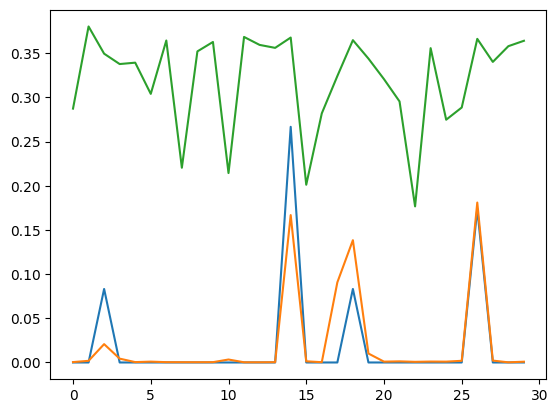

In [62]:
trainer.decoder.eval()
trainer.encoder.eval()
dataset = train_dataset
with torch.no_grad():
    index = np.random.randint(0,len(dataset))
    data_point = dataset[index]
    point = torch.tensor(data_point["data"]).unsqueeze(0).float().to(device)
    labels = torch.tensor(data_point["label"]).to(device)
    print(labels.item())
  
    cond_id = trainer.ortho_vectors[labels].view(1,-1)
    mu,log_var = trainer._getEncoderOut(X = point,cond=  cond_id)
    z_id = trainer._sampleZ(mu= mu,log_var= log_var)
    out_id = trainer._getDecoderOut(z_id,cond= cond_id)[0]

    ood_index =  labels.item()#VAETrainer.sampleIndex(curr_index= labels.item(),max_index= 10)
    cond_ood = trainer.ortho_vectors[ood_index].view(1,-1)
    mu_ood,log_var_ood = trainer._getEncoderOut(X = point,cond=  cond_ood)
    z_ood = trainer._sampleZ(mu= mu_ood,log_var= log_var_ood)
    print(ood_index)
    choices = np.arange(len(dataset.label_to_index),trainer.ortho_vectors.size(0))
    ood_index =  np.random.choice(choices,1).item()

    cond_ood = trainer.ortho_vectors[ood_index].view(1,-1)
    out_ood = trainer._getDecoderOut(z_ood,cond_ood)[0]

    print(ood_index)

    #print(pairwise_distances(X= training_arrays,Y = out_ood.view(out_ood.size(0),-1).cpu().numpy(), metric= "l2").min())


plt.plot(point.cpu()[0,:,0])
plt.plot(out_id.cpu()[0,:,0])
plt.plot(out_ood.cpu()[0,:,0])

13

In [ ]:
np.random.choice()

In [32]:
def getSamplesAndLabels(dataset,trainer : VAETrainer):
    loader = DataLoader(dataset,batch_size = 64)
    encoder = trainer.encoder
    encoder.eval()
    samples = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            X = batch["data"].float().to(device)
            y = batch["label"].tolist()
            mu,log_var = trainer._getEncoderOut(X)
            sample = trainer._sampleZ(mu= mu, log_var= log_var,ood= False).cpu().numpy().tolist()

            samples.extend(mu.cpu().numpy().tolist())
            labels.extend(y)
    
    result = dict()
    for i in range(len(samples)):
        key = labels[i]
        if key not in result:
            result[key] = []
        else:
            result[key].append(samples[i])

    for key in result:
        result[key] = np.array(result[key])
    return result



In [33]:
sample_dict = getSamplesAndLabels(dataset= train_dataset,trainer= trainer)

[2024-04-17 12:30:11,873] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-04-17 12:30:11,873] torch._dynamo.convert_frame: [WARNING]    function: 'forward' (/home/captanlevi/Desktop/UNSW/flowprintOptimal/sekigo/modeling/neuralNetworks.py:310)
[2024-04-17 12:30:11,873] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2024-04-17 12:30:11,873] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2024-04-17 12:30:11,873] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.


In [34]:
X = np.array(sample_dict[0].tolist() + sample_dict[1].tolist() )
X_ood = soft_brownian_offset(X, d_min=40, d_off= 2, n_samples=100, softness=0)

In [35]:
X_ood.shape

(100, 100)

In [36]:
from sklearn.metrics import pairwise_distances


pairwise_distances(sample_dict[0],sample_dict[1]).max()

49.74899803705561

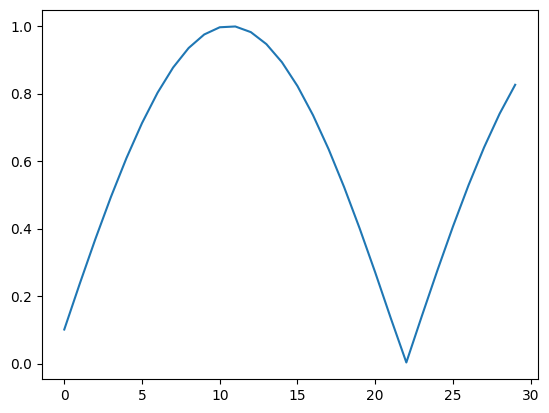

In [95]:
plt.plot(train_dataset[1]["data"][:,0])

In [113]:
alpha = .76
mid = sample_dict[0][0]*alpha + sample_dict[1][10]*(1- alpha)

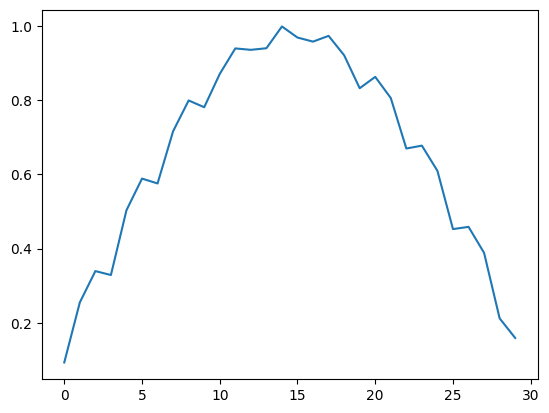

In [114]:
with torch.no_grad():
    out = trainer.decoder(torch.tensor(mid).unsqueeze(0).float().to(device))
    out = out.cpu().numpy()[0,:,0]
plt.plot(out)

(1637, 2) 1637 5202
(1719, 2) 3356 5202
(1746, 2) 5102 5202


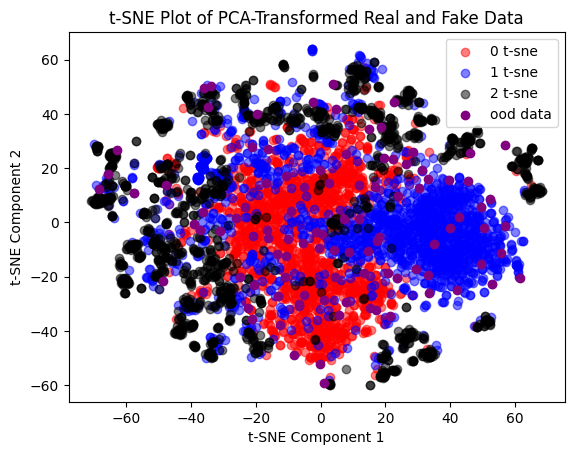

In [37]:
from sklearn.manifold import TSNE
colors = ["red", "blue", "black", "green","pink"]

# Fit t-SNE on PCA-transformed real data
tsne = TSNE(n_components=2, random_state=42)
all_data = []
for i in range(len(sample_dict)):
    all_data.extend(sample_dict[i].tolist())
all_data.extend(X_ood.tolist())
all_data = np.array(all_data)
tsne_data = tsne.fit_transform(all_data)


start_len = 0
for i in range(len(sample_dict)):
  
    tsne_label_data = tsne_data[start_len:start_len + len(sample_dict[i])]
    start_len += len(sample_dict[i])

    print(tsne_label_data.shape,start_len,len(tsne_data))
    plt.scatter(tsne_label_data[:,0], tsne_label_data[:,1],label = "{} t-sne".format(i),c= colors[i],alpha= .5)




plt.scatter(tsne_data[start_len:-1][:,0],tsne_data[start_len:-1][:,1],label = "ood data",c = "purple",alpha= 1)
# Plot t-SNE of PCA-transformed real and fake data
#plt.scatter(tsne_real_data[:, 0], tsne_real_data[:, 1], label='Real Data (PCA+t-SNE)', c='blue', alpha=0.1)
#plt.scatter(tsne_fake_data[:, 0], tsne_fake_data[:, 1], label='Fake Data (PCA+t-SNE)', c='red', alpha=0.1)

# Add labels and legend
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot of PCA-Transformed Real and Fake Data')
plt.legend()


In [17]:
train_dataset.label_to_index

{'chat': 0, 'control': 1, 'streaming': 2}